<a href="https://colab.research.google.com/github/abdulquawiyy-owolabi/Deep-Learning/blob/main/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install dependencies
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --use-pep517 --quiet
!pip install torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import torch
import random

import numpy as np
import matplotlib.pylab as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from pytorch_pretrained_biggan import one_hot_from_names

from tqdm.notebook import tqdm, trange

In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, HBox, Layout, VBox
from ipywidgets import interactive_output, Dropdown

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Helper functions


def image_moments(image_batches, n_batches=None):
  """
  Compute mean and covariance of all pixels
  from batches of images

  Args:
    Image_batches: tuple
      Image batches
    n_batches: int
      Number of Batch size

  Returns:
    m1: float
      Mean of all pixels
    cov: float
      Covariance of all pixels
  """
  m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
  n = 0
  for im in tqdm(image_batches, total=n_batches, leave=False,
                 desc='Computing pixel mean and covariance...'):
    im = im.to(DEVICE)
    b = im.size()[0]
    im = im.view(b, -1)
    m1 = m1 + im.sum(dim=0)
    m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
    n += b
  m1, m2 = m1/n, m2/n
  cov = m2 - m1.view(-1,1)*m1.view(1,-1)
  return m1.cpu(), cov.cpu()


def interpolate(A, B, num_interps):
  """
  Function to interpolate between images.
  It does this by linearly interpolating between the
  probability of each category you select and linearly
  interpolating between the latent vector values.

  Args:
    A: list
      List of categories
    B: list
      List of categories
    num_interps: int
      Quantity of pixel grids

  Returns:
    Interpolated np.ndarray
  """
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])


def kl_q_p(zs, phi):
  """
  Given [b,n,k] samples of z drawn
  from q, compute estimate of KL(q||p).
  phi must be size [b,k+1]
  This uses mu_p = 0 and sigma_p = 1,
  which simplifies the log(p(zs)) term to
  just -1/2*(zs**2)

  Args:
    zs: list
      Samples
    phi: list
      Relative entropy

  Returns:
    Size of log_q and log_p is [b,n,k].
    Sum along [k] but mean along [b,n]
  """
  b, n, k = zs.size()
  mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
  log_p = -0.5*(zs**2)
  log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
  # Size of log_q and log_p is [b,n,k].
  # Sum along [k] but mean along [b,n]
  return (log_q - log_p).sum(dim=2).mean(dim=(0,1))


def log_p_x(x, mu_xs, sig_x):
  """
  Given [batch, ...] input x and
  [batch, n, ...] reconstructions, compute
  pixel-wise log Gaussian probability
  Sum over pixel dimensions, but mean over batch
  and samples.

  Args:
    x: np.ndarray
      Input Data
    mu_xs: np.ndarray
      Log of mean of samples
    sig_x: np.ndarray
      Log of standard deviation

  Returns:
    Mean over batch and samples.
  """
  b, n = mu_xs.size()[:2]
  # Flatten out pixels and add a singleton
  # dimension [1] so that x will be
  # implicitly expanded when combined with mu_xs
  x = x.reshape(b, 1, -1)
  _, _, p = x.size()
  squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

  # Size of squared_error is [b,n,p]. log prob is
  # by definition sum over [p].
  # Expected value requires mean over [n].
  # Handling different size batches
  # requires mean over [b].
  return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))


def pca_encoder_decoder(mu, cov, k):
  """
  Compute encoder and decoder matrices
  for PCA dimensionality reduction

  Args:
    mu: np.ndarray
      Mean
    cov: float
      Covariance
    k: int
      Dimensionality

  Returns:
    Nothing
  """
  mu = mu.view(1,-1)
  u, s, v = torch.svd_lowrank(cov, q=k)
  W_encode = v / torch.sqrt(s)
  W_decode = u * torch.sqrt(s)

  def pca_encode(x):
    """
    Encoder: Subtract mean image and
    project onto top K eigenvectors of
    the data covariance

    Args:
      x: torch.tensor
        Input data

    Returns:
      PCA Encoding
    """
    return (x.view(-1,mu.numel()) - mu) @ W_encode

  def pca_decode(h):
    """
    Decoder: un-project then add back in the mean

    Args:
      h: torch.tensor
        Hidden layer data

    Returns:
      PCA Decoding
    """
    return (h @ W_decode.T) + mu

  return pca_encode, pca_decode


def cout(x, layer):
  """
  Unnecessarily complicated but complete way to
  calculate the output depth, height
  and width size for a Conv2D layer

  Args:
    x: tuple
      Input size (depth, height, width)
    layer: nn.Conv2d
      The Conv2D layer

  Returns:
    Tuple of out-depth/out-height and out-width
    Output shape as given in [Ref]
    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

In [ ]:
# @title Plotting functions

def plot_gen_samples_ppca(therm1, therm2, therm_data_sim):
  """
  Plotting generated samples

  Args:
    therm1: list
      Thermometer 1
    them2: list
      Thermometer 2
    therm_data_sim: list
      Generated (simulate, draw) `n_samples` from pPCA model

  Returns:
    Nothing
  """
  plt.plot(therm1, therm2, '.', c='c', label='training data')
  plt.plot(therm_data_sim[0], therm_data_sim[1], '.', c='m', label='"generated" data')
  plt.axis('equal')
  plt.xlabel('Thermometer 1 ($^\circ$C)')
  plt.ylabel('Thermometer 2 ($^\circ$C)')
  plt.legend()
  plt.show()


def plot_linear_ae(lin_losses):
  """
  Plotting linear autoencoder

  Args:
    lin_losses: list
      Log of linear autoencoder MSE losses

  Returns:
    Nothing
  """
  plt.figure()
  plt.plot(lin_losses)
  plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.show()


def plot_conv_ae(lin_losses, conv_losses):
  """
  Plotting convolutional autoencoder

  Args:
    lin_losses: list
      Log of linear autoencoder MSE losses
    conv_losses: list
      Log of convolutional model MSe losses

  Returns:
    Nothing
  """
  plt.figure()
  plt.plot(lin_losses)
  plt.plot(conv_losses)
  plt.legend(['Lin AE', 'Conv AE'])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.ylim([0,
            2*max(torch.as_tensor(conv_losses).median(),
                  torch.as_tensor(lin_losses).median())])
  plt.show()


def plot_images(images, h=3, w=3, plt_title=''):
  """
  Helper function to plot images

  Args:
    images: torch.tensor
      Images
    h: int
      Image height
    w: int
      Image width
    plt_title: string
      Plot title

  Returns:
    Nothing
  """
  plt.figure(figsize=(h*2, w*2))
  plt.suptitle(plt_title, y=1.03)
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])
  plt.axis('off')
  plt.show()

def plot_phi(phi, num=4):
  """
  Contour plot of relative entropy across samples

  Args:
    phi: list
      Log of relative entropu changes
    num: int
      Number of interations
  """
  plt.figure(figsize=(12, 3))
  for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.scatter(zs[i, :, 0], zs[i, :, 1], marker='.')
    th = torch.linspace(0, 6.28318, 100)
    x, y = torch.cos(th), torch.sin(th)
    # Draw 2-sigma contours
    plt.plot(
        2*x*phi[i, 2].exp().item() + phi[i, 0].item(),
        2*y*phi[i, 2].exp().item() + phi[i, 1].item()
        )
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.grid()
    plt.axis('equal')
  plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
  plt.show()


def plot_torch_image(image, ax=None):
  """
  Helper function to plot torch image

  Args:
    image: torch.tensor
      Image
    ax: plt object
      If None, plt.gca()

  Returns:
    Nothing
  """
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # Torch images have shape (channels, height, width)
  # but matplotlib expects
  # (height, width, channels) or just
  # (height,width) when grayscale
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

In [ ]:
# @title Set random seed
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [ ]:
# @title Download `wordnet` dataset

"""
NLTK Download:

import nltk
nltk.download('wordnet')
"""

import os, requests, zipfile

os.environ['NLTK_DATA'] = 'nltk_data/'

fnames = ['wordnet.zip', 'omw-1.4.zip']
urls = ['https://osf.io/ekjxy/download', 'https://osf.io/kuwep/download']

for fname, url in zip(fnames, urls):
  r = requests.get(url, allow_redirects=True)

  with open(fname, 'wb') as fd:
    fd.write(r.content)

  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('nltk_data/corpora')

In [ ]:
# @title Download BigGAN and some Image Datasets

url = "https://osf.io/3yvhw/download"
fname = "biggan_deep_256"
r = requests.get(url, allow_redirects=True)

with open(fname, 'wb') as fd:
  fd.write(r.content)
biggan_model = torch.load(fname, weights_only=False)

In [ ]:
# @title BigGAN Image Generator (the updates may take a few seconds, please be patient)

# category = 'German shepherd' # @param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
# z_magnitude = .1 # @param {type:"slider", min:0, max:1, step:.1}


from scipy.stats import truncnorm
def truncated_noise_sample(batch_size=1, dim_z=128, truncation=1., seed=None):
    """ Create a truncated noise vector.
        Params:
            batch_size: batch size.
            dim_z: dimension of z
            truncation: truncation value to use
            seed: seed for the random generator
        Output:
            array of shape (batch_size, dim_z)
    """
    state = None if seed is None else np.random.RandomState(seed)
    values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state).astype(np.float32)
    return truncation * values


def sample_from_biggan(category, z_magnitude):
  """
  Sample from BigGAN Image Generator

  Args:
    category: string
      Category
    z_magnitude: int
      Magnitude of variation vector

  Returns:
    Nothing
  """

  truncation = z_magnitude
  z = truncated_noise_sample(truncation=truncation, batch_size=4)
  y = one_hot_from_names(category, batch_size=4)

  z = torch.from_numpy(z)
  z = z.float()
  y = torch.from_numpy(y)

  # Move to GPU
  z = z.to(device=set_device())
  y = y.to(device=set_device())
  biggan_model.to(device=set_device())


  with torch.no_grad():
    output = biggan_model(z, y, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer,
  # resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1]
  # range.
  # Clipping is only in case of numerical instability
  # problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)

  fig, axes = plt.subplots(2, 2)
  axes = axes.flatten()
  for im in range(4):

    axes[im].imshow(output[im].squeeze().moveaxis(0,-1))
    axes[im].axis('off')

z_slider = FloatSlider(min=.1, max=1, step=.1, value=0.1,
                     continuous_update=False,
                     description='Truncation Value',
                     style = {'description_width': '100px'},
                     layout=Layout(width='440px'))

category_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="German shepherd",
             description="Category: ")

widgets_ui = VBox([category_dropdown, z_slider])

widgets_out = interactive_output(sample_from_biggan,
                                 {
                                  'z_magnitude': z_slider,
                                  'category': category_dropdown
                                  }
                                 )

display(widgets_ui, widgets_out)

Output()

In [ ]:
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed!\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.\n')


fname = 'cifar-10-python.tar.gz'
name = 'cifar10'
url = 'https://osf.io/jbpme/download'

if not os.path.exists(name):
  print('\nDownloading CIFAR10 dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading CIFAR10 completed!')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('CIFAR10 dataset has been dowloaded.')

MNIST dataset has been downloaded.

CIFAR10 dataset has been dowloaded.


In [ ]:
# MNIST
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

# CIFAR 10
cifar10 = datasets.CIFAR10('./cifar10/',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)
cifar10_val = datasets.CIFAR10('./cifar10/',
                               train=False,
                               transform=transforms.ToTensor(),
                               download=False)

In [ ]:
def get_data(name='mnist'):
  """
  Get data

  Args:
    name: string
      Name of the dataset

  Returns:
    my_dataset: dataset instance
      Instance of dataset
    my_dataset_name: string
      Name of the dataset
    my_dataset_shape: tuple
      Shape of dataset
    my_dataset_size: int
      Size of dataset
    my_valset: torch.loader
      Validation loader
  """
  if name == 'mnist':
    my_dataset_name = "MNIST"
    my_dataset = mnist
    my_valset = mnist_val
    my_dataset_shape = (1, 28, 28)
    my_dataset_size = 28 * 28
  elif name == 'cifar10':
    my_dataset_name = "CIFAR10"
    my_dataset = cifar10
    my_valset = cifar10_val
    my_dataset_shape = (3, 32, 32)
    my_dataset_size = 3 * 32 * 32

  return my_dataset, my_dataset_name, my_dataset_shape, my_dataset_size, my_valset

In [ ]:
dataset_name = 'mnist'  # This can be mnist or cifar10
train_set, dataset_name, data_shape, data_size, valid_set = get_data(name=dataset_name)

In [ ]:
def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  """
  Function to train autoencoder

  Args:
    autoencoder: nn.module
      Autoencoder instance
    dataset: function
      Dataset
    device: string
      GPU if available. CPU otherwise
    epochs: int
      Number of epochs [default: 20]
    batch_size: int
      Batch size
    seed: int
      Set seed for reproducibility; [default: 0]

  Returns:
    mse_loss: float
      MSE Loss
  """
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # Loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
  # After training completes,
  # make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss.cpu()

Random seed 2021 has been set.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

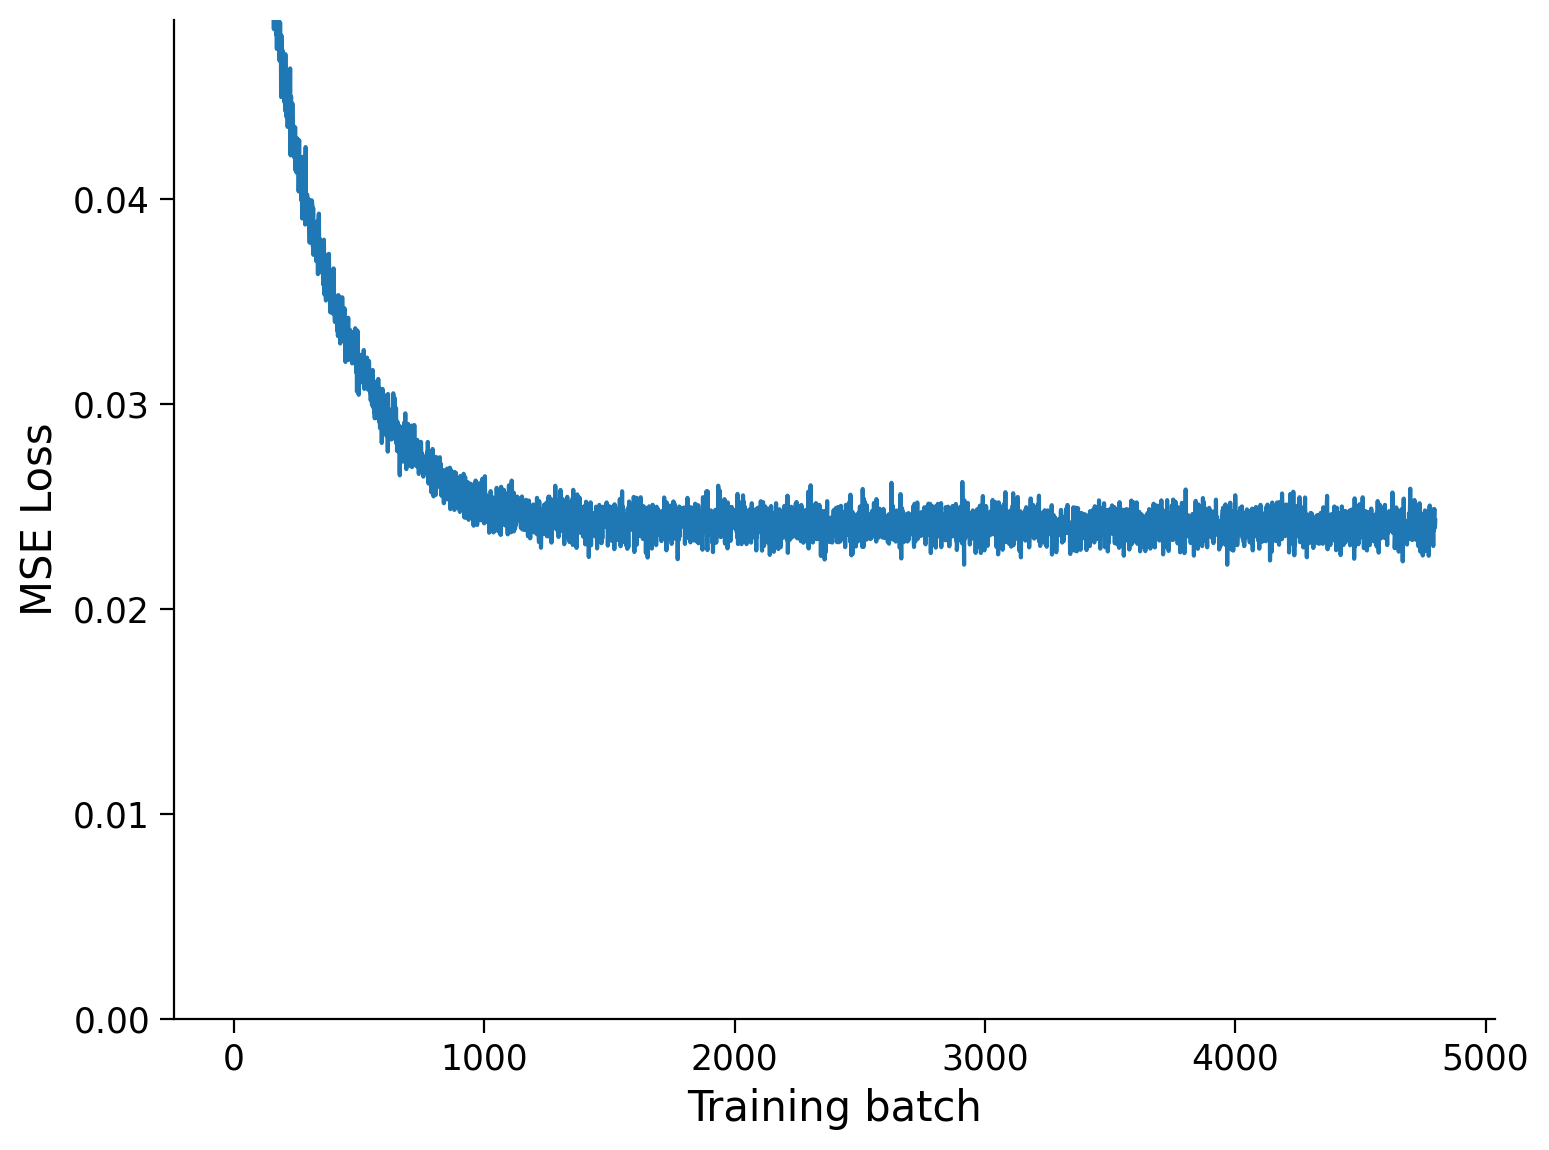

In [ ]:
class LinearAutoEncoder(nn.Module):
  """
  Linear Autoencoder
  """

  def __init__(self, x_dim, h_dim):
    """
    A Linear AutoEncoder

    Args:
      x_dim: int
        Input dimension
      h_dim: int
        Hidden dimension, bottleneck dimension, K

    Returns:
      Nothing
    """
    super().__init__()

    # Encoder layer (a linear mapping from x_dim to K)
    self.enc_lin = nn.Linear(x_dim, h_dim)
    # Decoder layer (a linear mapping from K to x_dim)
    self.dec_lin = nn.Linear(h_dim, x_dim)

  def encode(self, x):
    """
    Encoder function

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Encoded output
    """

    h = self.enc_lin(x)
    return h

  def decode(self, h):
    """
    Decoder function

    Args:
      h: torch.tensor
        Encoded output

    Returns:
      x_prime: torch.tensor
        Decoded output
    """
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input data

    Returns:
      Decoded output
    """
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())



# Pick your own K
K = 20
set_seed(seed=SEED)

lin_ae = LinearAutoEncoder(data_size, K)
lin_losses = train_autoencoder(lin_ae, train_set, device=DEVICE, seed=SEED)
plot_linear_ae(lin_losses)

In [ ]:
# PCA requires finding the top K eigenvectors of the data covariance. Start by
# finding the mean and covariance of the pixels in our dataset
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

loader = DataLoader(train_set,
                    batch_size=32,
                    pin_memory=True,
                    num_workers=2,
                    worker_init_fn=seed_worker,
                    generator=g_seed)

mu, cov = image_moments((im for im, _ in loader),
                        n_batches=len(train_set) // 32)

pca_encode, pca_decode = pca_encoder_decoder(mu, cov, K)

Computing pixel mean and covariance...:   0%|          | 0/1875 [00:00<?, ?it/s]

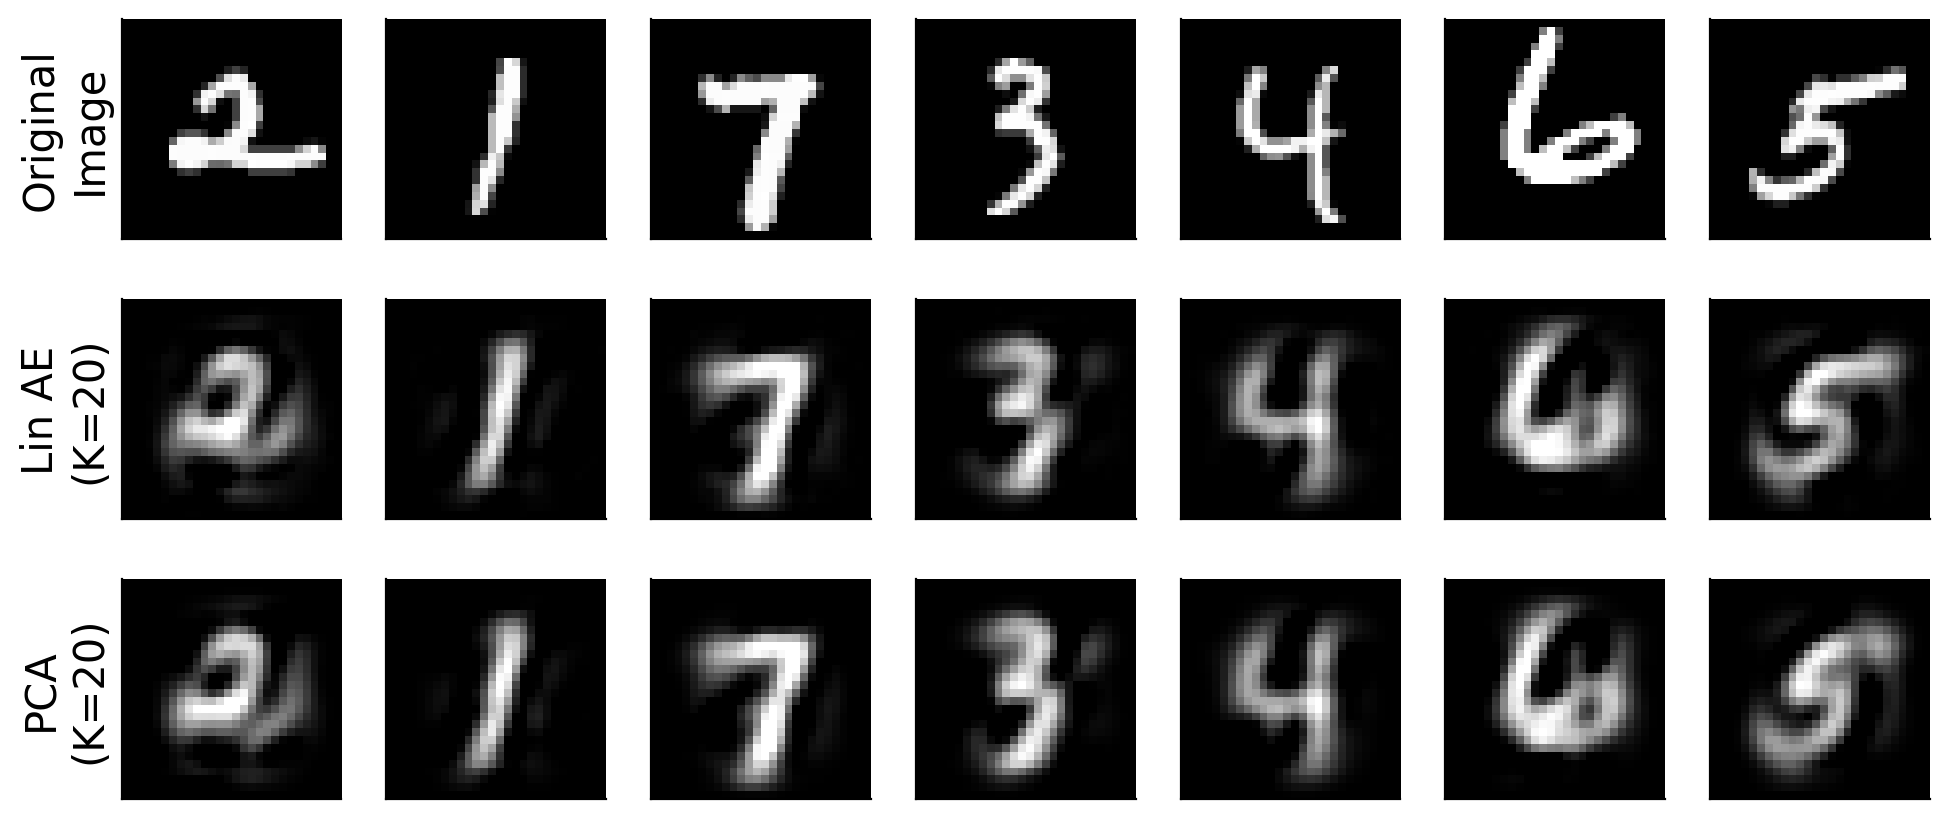

In [ ]:
n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  # Get reconstructed image from autoencoder
  with torch.no_grad():
    reconstruction = lin_ae(image.unsqueeze(0)).reshape(image.size())

  # Get reconstruction from PCA dimensionality reduction
  h_pca = pca_encode(image)
  recon_pca = pca_decode(h_pca).reshape(image.size())

  plt.subplot(3, n_plot, i + 1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(reconstruction)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(recon_pca)
  if i == 0:
    plt.ylabel(f'PCA\n(K={K})')
plt.show()

In [ ]:
class BiasLayer(nn.Module):
  def __init__(self, shape):
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    return x + self.bias

In [ ]:
dummy_image = torch.rand(data_shape).unsqueeze(0)
in_channel = data_shape[0]
out_channel = 7

dummy_conv = nn.Conv2d(in_channels=in_channel,
                       out_channels=out_channel,
                       kernel_size=5)
dummy_deconv = nn.ConvTranspose2d(in_channels=out_channel,
                               out_channels=in_channel,
                               kernel_size=5)

print(f"Size of image is {dummy_image.size()}")
print(f"Size of Conv2D(image) {dummy_conv(dummy_image).shape}")
print(f"Size of ConvTranspose2D(image) {dummy_deconv(dummy_conv(dummy_image)).shape}")

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 7, 24, 24])
Size of ConvTranspose2D(image) torch.Size([1, 1, 28, 28])


Random seed 2021 has been set.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

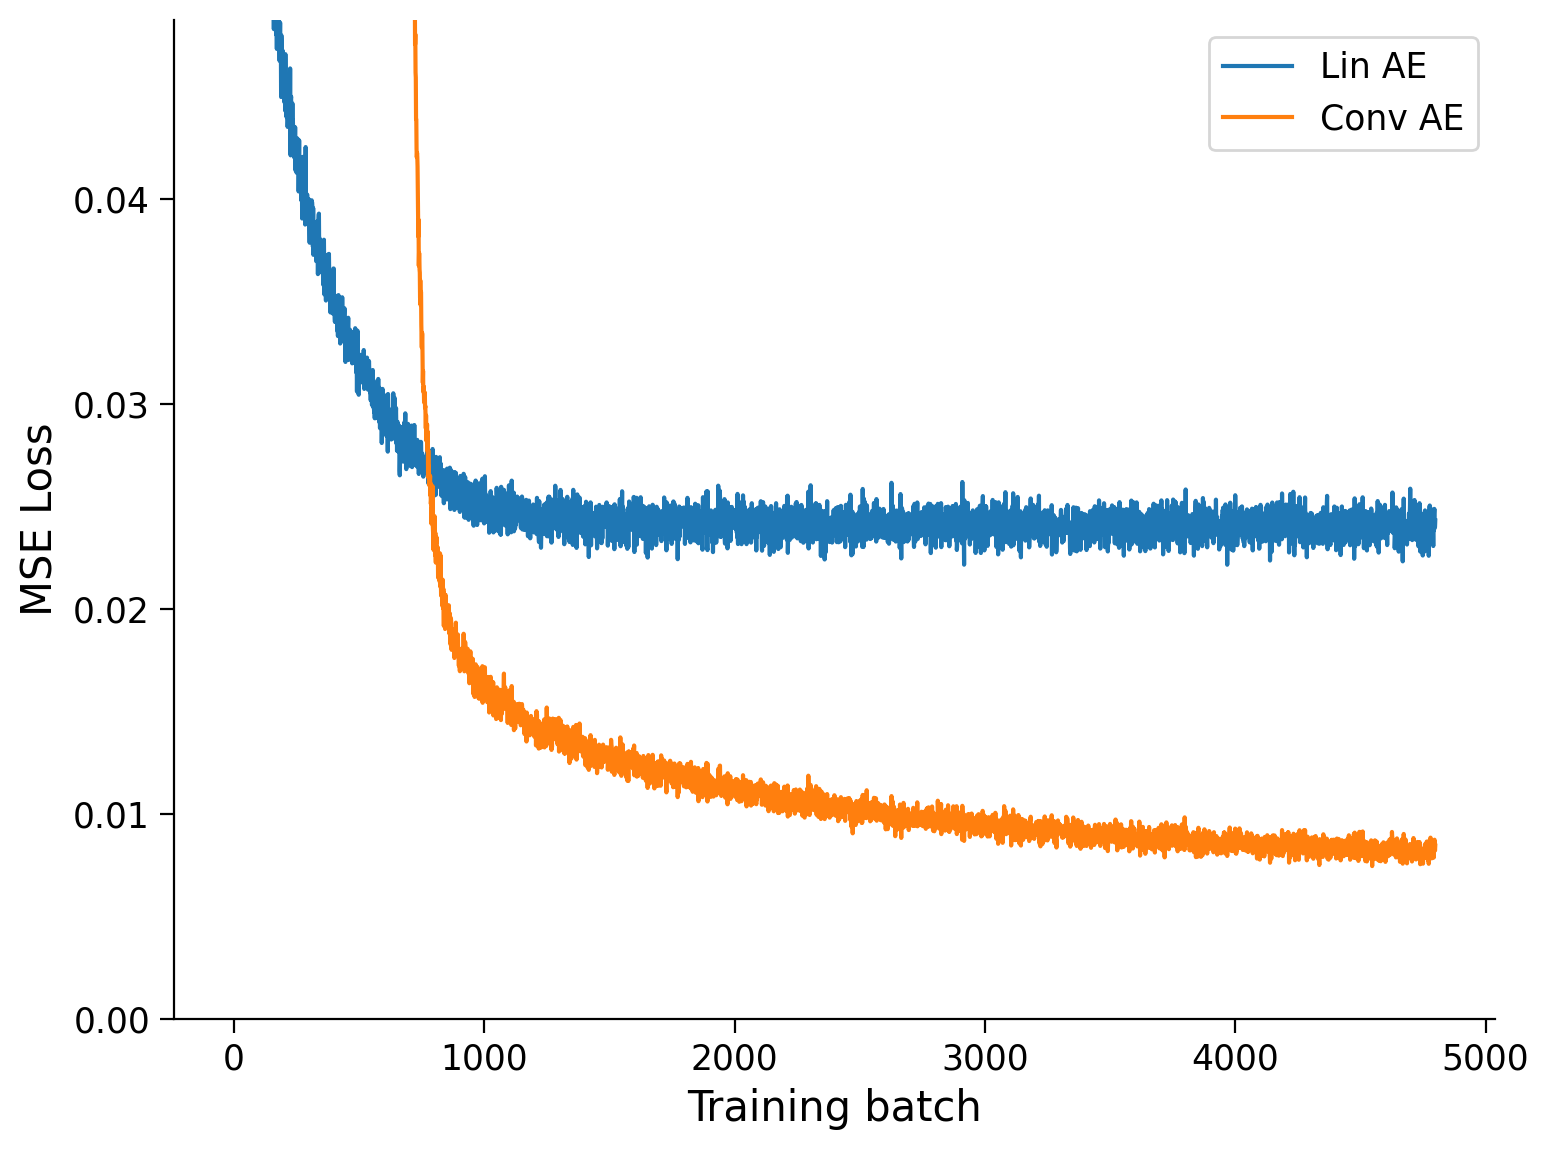

In [ ]:
class ConvAutoEncoder(nn.Module):
  """
  A Convolutional AutoEncoder
  """

  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """
    Initialize parameters of ConvAutoEncoder

    Args:
      x_dim: tuple
        Input dimensions (channels, height, widths)
      h_dim: int
        Hidden dimension, bottleneck dimension, K
      n_filters: int
        Number of filters (number of output channels)
      filter_size: int
        Kernel size

    Returns:
      Nothing
    """
    super().__init__()
    channels, height, widths = x_dim

    # Encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # First encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # Output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # Second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # Output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # Conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # Encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    # Decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # Unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # First "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # Second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # Decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    """
    Encoder

    Args:
      x: torch.tensor
        Input features

    Returns:
      h: torch.tensor
        Encoded output
    """
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    """
    Decoder

    Args:
      h: torch.tensor
        Encoded output

    Returns:
      x_prime: torch.tensor
        Decoded output
    """
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input features

    Returns:
      Decoded output
    """
    return self.decode(self.encode(x))



set_seed(seed=SEED)


trained_conv_AE = ConvAutoEncoder(data_shape, K)
assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
plot_conv_ae(lin_losses, conv_losses)

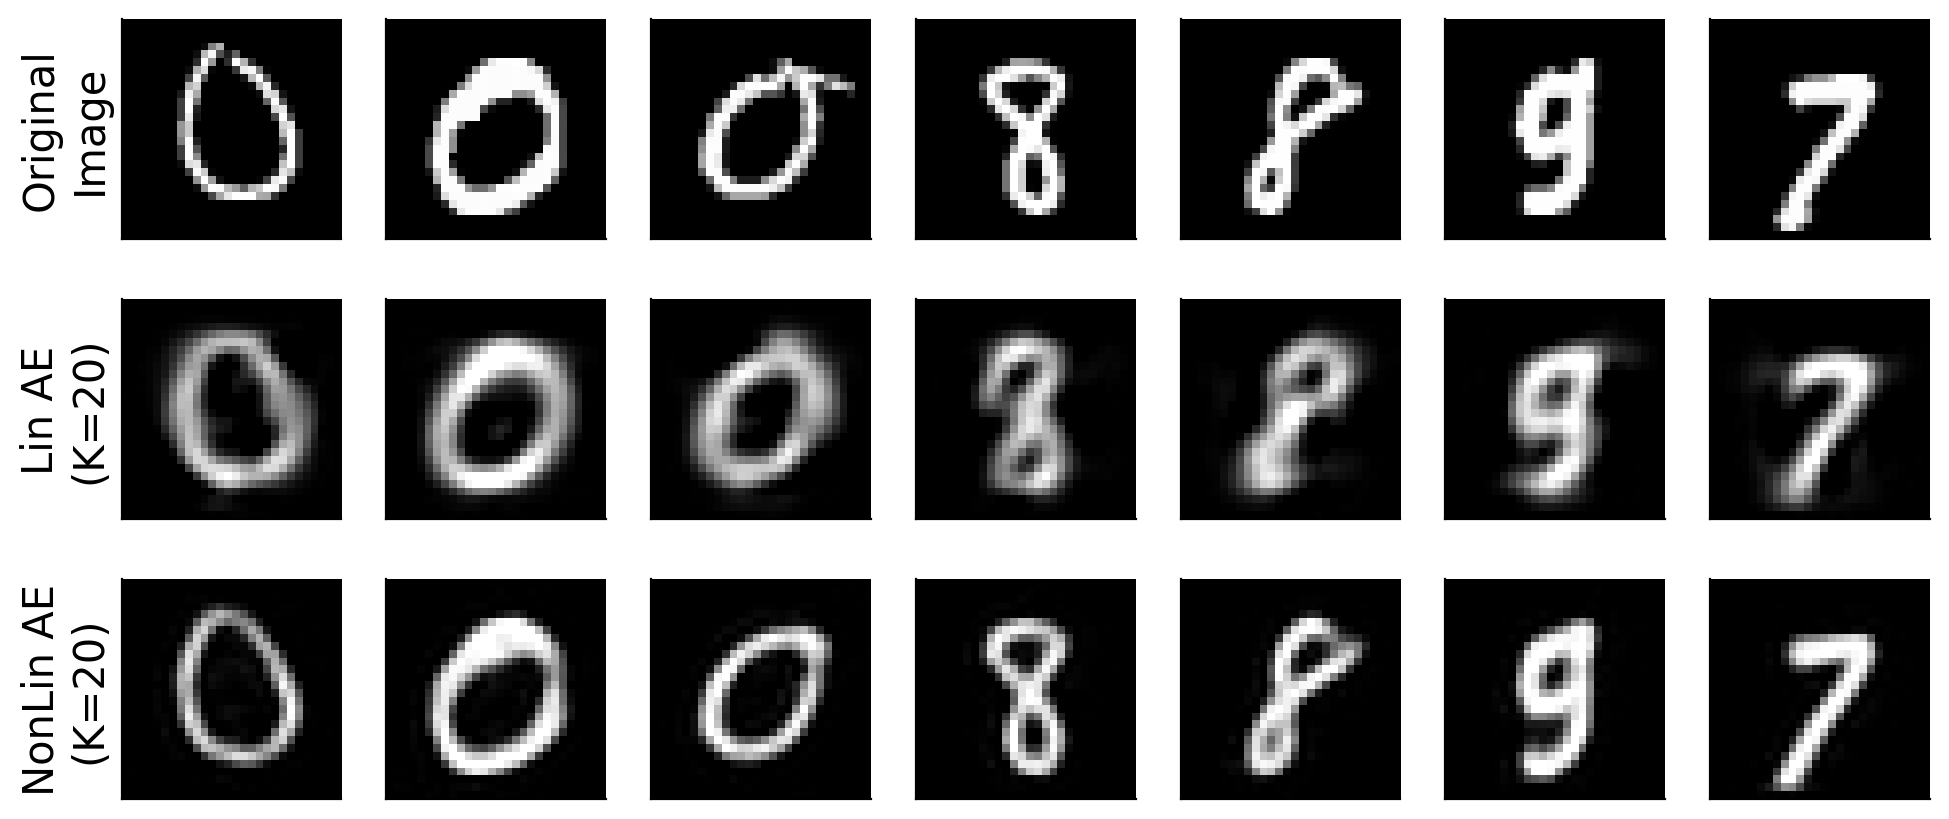

In [ ]:

if lin_ae.enc_lin.out_features != trained_conv_AE.enc_lin.out_features:
   raise ValueError('ERROR: your linear and convolutional autoencoders have different values of K')

n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  with torch.no_grad():
    # Get reconstructed image from linear autoencoder
    lin_recon = lin_ae(image.unsqueeze(0))[0]

    # Get reconstruction from deep (nonlinear) autoencoder
    nonlin_recon = trained_conv_AE(image.unsqueeze(0))[0]

  plt.subplot(3, n_plot, i+1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(lin_recon)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(nonlin_recon)
  if i == 0:
    plt.ylabel(f'NonLin AE\n(K={K})')
plt.show()

In [ ]:
K_VAE = 2


class ConvVAE(nn.Module):
  """
  Convolutional Variational Autoencoder
  """
  def __init__(self, K, num_filters=32, filter_size=5):
    """
    Initialize parameters of ConvVAE

    Args:
      K: int
        Bottleneck dimensionality
      num_filters: int
        Number of filters [default: 32]
      filter_size: int
        Filter size [default: 5]

    Returns:
      Nothing
    """

    super(ConvVAE, self).__init__()

    # With padding=0, the number of pixels cut off from
    # each image dimension
    # is filter_size // 2. Double it to get the amount
    # of pixels lost in
    # width and height per Conv2D layer, or added back
    # in per
    # ConvTranspose2D layer.
    filter_reduction = 2 * (filter_size // 2)

    # After passing input through two Conv2d layers,
    # the shape will be
    # 'shape_after_conv'. This is also the shape that
    # will go into the first
    # deconvolution layer in the decoder
    self.shape_after_conv = (num_filters,
                              data_shape[1]-2*filter_reduction,
                              data_shape[2]-2*filter_reduction)
    flat_size_after_conv = self.shape_after_conv[0] \
        * self.shape_after_conv[1] \
        * self.shape_after_conv[2]

    # Define the recognition model (encoder or q) part
    self.q_bias = BiasLayer(data_shape)
    self.q_conv_1 = nn.Conv2d(data_shape[0], num_filters, 5)
    self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
    self.q_flatten = nn.Flatten()
    self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

    # Define the generative model (decoder or p) part
    self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
    self.p_unflatten = nn.Unflatten(-1, self.shape_after_conv)
    self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
    self.p_deconv_2 = nn.ConvTranspose2d(num_filters, data_shape[0], 5)
    self.p_bias = BiasLayer(data_shape)

    # Define a special extra parameter to learn
    # scalar sig_x for all pixels
    self.log_sig_x = nn.Parameter(torch.zeros(()))

  def infer(self, x):
    """
    Map (batch of) x to (batch of) phi which
    can then be passed to
    rsample to get z

    Args:
      x: torch.tensor
        Input features

    Returns:
      phi: np.ndarray
        Relative entropy
    """
    s = self.q_bias(x)
    s = F.relu(self.q_conv_1(s))
    s = F.relu(self.q_conv_2(s))
    flat_s = s.view(s.size()[0], -1)
    phi = self.q_fc_phi(flat_s)
    return phi

  def generate(self, zs):
    """
    Map [b,n,k] sized samples of z to
    [b,n,p] sized images

    Args:
      zs: np.ndarray
        Samples

    Returns:
      mu_zs: np.ndarray
        Mean of samples
    """
    # Note that for the purposes of passing
    # through the generator, we need
    # to reshape zs to be size [b*n,k]
    b, n, k = zs.size()
    s = zs.view(b*n, -1)
    s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
    s = F.relu(self.p_deconv_1(s))
    s = self.p_deconv_2(s)
    s = self.p_bias(s)
    mu_xs = s.view(b, n, -1)
    return mu_xs

  def decode(self, zs):
    """
    Decoder

    Args:
      zs: np.ndarray
        Samples

    Returns:
      Generated images
    """
    # Included for compatability with conv-AE code
    return self.generate(zs.unsqueeze(0))

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input image

    Returns:
      Generated images
    """
    # VAE.forward() is not used for training,
    # but we'll treat it like a
    # classic autoencoder by taking a single
    # sample of z ~ q
    phi = self.infer(x)
    zs = rsample(phi, 1)
    return self.generate(zs).view(x.size())

  def elbo(self, x, n=1):
    """
    Run input end to end through the VAE
    and compute the ELBO using n
    samples of z

    Args:
      x: torch.tensor
        Input image
      n: int
        Number of samples of z

    Returns:
      Difference between true and estimated KL divergence
    """
    phi = self.infer(x)
    zs = rsample(phi, n)
    mu_xs = self.generate(zs)
    return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)


def expected_z(phi):
  """
  Expected sample entropy

  Args:
    phi: list
      Relative entropy

  Returns:
    Expected sample entropy
  """
  return phi[:, :-1]


def rsample(phi, n_samples):
  """
  Sample z ~ q(z;phi)
  Output z is size [b,n_samples,K] given
  phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q,
  and phi[:,-1] is the log
  standard deviation

  Args:
    phi: list
      Relative entropy
    n_samples: int
      Number of samples

  Returns:
    Output z is size [b,n_samples,K] given
  phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q,
  and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1-1
  mu, sig = phi[:, :-1], phi[:,-1].exp()
  eps = torch.randn(b, n_samples, k, device=phi.device)
  return eps*sig.view(b,1,1) + mu.view(b,1,k)


def train_vae(vae, dataset, epochs=10, n_samples=1000):
  """
  Train VAE

  Args:
    vae: nn.module
      Model
    dataset: function
      Dataset
    epochs: int
      Epochs
    n_samples: int
      Number of samples

  Returns:
    elbo_vals: list
      List of values obtained from ELBO
  """
  opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=0)
  elbo_vals = []
  vae.to(DEVICE)
  vae.train()
  loader = DataLoader(dataset, batch_size=250, shuffle=True, pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    for im, _ in tqdm(loader, total=len(dataset) // 250, desc='Batches', leave=False):
      im = im.to(DEVICE)
      opt.zero_grad()
      loss = -vae.elbo(im)
      loss.backward()
      opt.step()

      elbo_vals.append(-loss.item())
  vae.to('cpu')
  vae.eval()
  return elbo_vals


trained_conv_VarAE = ConvVAE(K=K_VAE)
elbo_vals = train_vae(trained_conv_VarAE, train_set, n_samples=10000)

print(f'Learned sigma_x is {torch.exp(trained_conv_VarAE.log_sig_x)}')

# Uncomment below if you'd like to see the the training
# curve of the evaluated ELBO loss function
# ELBO is the loss function used to train VAEs
# (see lecture!)
plt.figure()
plt.plot(elbo_vals)
plt.xlabel('Batch #')
plt.ylabel('ELBO')
plt.show()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
def generate_images(autoencoder, K, n_images=1):
  """
  Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  Args:
    autoencoder: nn.module
      Autoencoder model
    K: int
      Bottleneck dimension
    n_images: int
      Number of images

  Returns:
    x: torch.tensor
      (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + data_shape
  with torch.no_grad():
    z = torch.randn(n_images, K, device=DEVICE) # Corrected line
    autoencoder.to(DEVICE) # Move the model to the same device as z
    x = autoencoder.decode(z)

    return x.reshape(output_shape)



set_seed(seed=SEED)


images = generate_images(trained_conv_AE, K, n_images=9)
plot_images(images, plt_title='Images Generated from the Conv-AE')
images = generate_images(trained_conv_VarAE, K_VAE, n_images=9)
plot_images(images, plt_title='Images Generated from a Conv-Variational-AE')

In [ ]:
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [ ]:
# @title Plotting functions
import logging
import pandas as pd
import matplotlib.lines as mlines
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['axes.unicode_minus'] = False
# You may have functions that plot results that aren't
# particularly interesting. You can add these here to hide them.

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps

   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )


def kdeplot(pnts, label="", ax=None, titlestr=None, handles=[], color="", **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, color=color, **kwargs)
  handles.append(mlines.Line2D([], [], color=color, label=label))
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

In [ ]:
 # @title 1D diffusion process
@widgets.interact
def diffusion_1d_forward(Lambda=(0, 50, 1), ):
  np.random.seed(0)
  timesteps = 100
  sampleN = 200
  t = np.linspace(0, 1, timesteps)
  # Generate random normal samples for the Wiener process
  dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), sampleN))  # Three-dimensional array for multiple trajectories
  # Sample initial positions from a bimodal distribution
  x0 = np.concatenate((np.random.normal(-5, 1, size=(sampleN//2)),
                       np.random.normal(5, 1, size=(sampleN - sampleN//2))), axis=-1)
  # Compute the diffusion process for multiple trajectories
  x = np.cumsum((Lambda**t[:,None]) * dw, axis=0) + x0.reshape(1,sampleN)  # Broadcasting x0 to match the shape of dw
  # Plot the diffusion process
  plt.plot(t, x[:,:sampleN//2], alpha=0.1, color="r") # traj from first mode
  plt.plot(t, x[:,sampleN//2:], alpha=0.1, color="b") # traj from second mode
  plt.xlabel('Time')
  plt.ylabel('x')
  plt.title('Diffusion Process with $g(t)=\lambda^{t}$'+f' $\lambda$={Lambda}')
  plt.grid(True)
  plt.show()

In [ ]:
# @title 2D diffusion process
Lambda = 26  # @param {type:"slider", min:1, max:50, step:1}
timesteps = 50
sampleN = 200
t = np.linspace(0, 1, timesteps)
# Generate random normal samples for the Wiener process
dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), 2, sampleN))  # Three-dimensional array for multiple trajectories
# Sample initial positions from a bimodal distribution
x0 = np.concatenate((np.random.normal(-2, .2, size=(2,sampleN//2)),
                     np.random.normal(2, .2, size=(2,sampleN - sampleN//2))),
                    axis=-1)
# Compute the diffusion process for multiple trajectories
x = np.cumsum((Lambda**t)[:, None, None] * dw, axis=0) + x0[None, :, :]  # Broadcasting x0 to match the shape of dw

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axis("image")
# Create an empty scatter plot
scatter1 = ax.scatter([], [], color="r", alpha=0.5)
scatter2 = ax.scatter([], [], color="b", alpha=0.5)
# Update function for the animation
def update(frame):
  ax.set_title(f'Time Step: {frame}')
  scatter1.set_offsets(x[frame, :, :sampleN//2].T)
  scatter2.set_offsets(x[frame, :, sampleN//2:].T)
  return scatter1, scatter2

# Create the animation
animation = FuncAnimation(fig, update, frames=range(timesteps), interval=100, blit=True)
# Display the animation
plt.close()  # Prevents displaying the initial static plot
HTML(animation.to_html5_video()) #  to_jshtml